Xception model  50 epoch batch size 32


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50, Training Loss: 0.5694, Training Accuracy: 0.6552, Validation Accuracy: 0.5333
Epoch 2/50, Training Loss: 0.1415, Training Accuracy: 0.9655, Validation Accuracy: 0.6667
Epoch 3/50, Training Loss: 0.0539, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 4/50, Training Loss: 0.0598, Training Accuracy: 0.9655, Validation Accuracy: 0.8667
Epoch 5/50, Training Loss: 0.1293, Training Accuracy: 0.9483, Validation Accuracy: 1.0000
Epoch 6/50, Training Loss: 0.0178, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 7/50, Training Loss: 0.0450, Training Accuracy: 0.9828, Validation Accuracy: 1.0000
Epoch 8/50, Training Loss: 0.0290, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 9/50, Training Loss: 0.0060, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 10/50, Training Loss: 0.0033, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 11/50, Training Loss: 0.0398, Training Accuracy: 0.9828, Validation Accuracy: 1.0000
Epoch 12

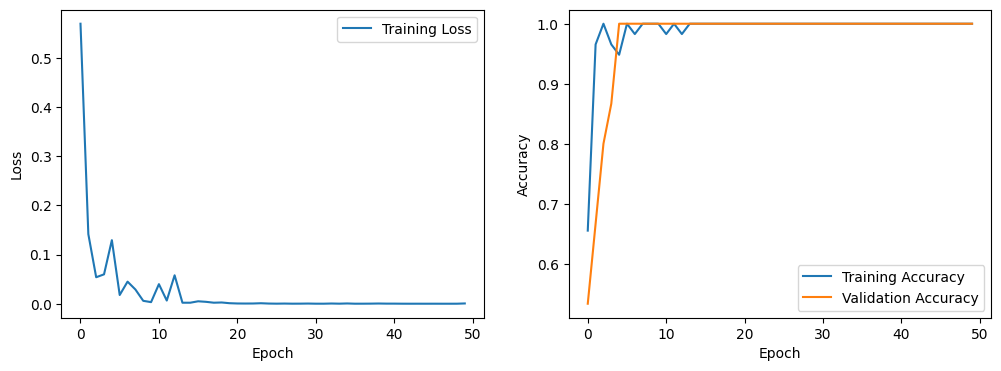

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
[[7 0]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import timm

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Xception 50 epoch batch size 64

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/50, Training Loss: 0.6797, Training Accuracy: 0.5690, Validation Accuracy: 1.0000
Epoch 2/50, Training Loss: 0.3384, Training Accuracy: 0.9828, Validation Accuracy: 0.7333
Epoch 3/50, Training Loss: 0.1716, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 4/50, Training Loss: 0.0631, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 5/50, Training Loss: 0.0110, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 6/50, Training Loss: 0.0050, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 7/50, Training Loss: 0.0029, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 8/50, Training Loss: 0.0020, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 9/50, Training Loss: 0.0015, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 10/50, Training Loss: 0.0011, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 11/50, Training Loss: 0.0009, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 12

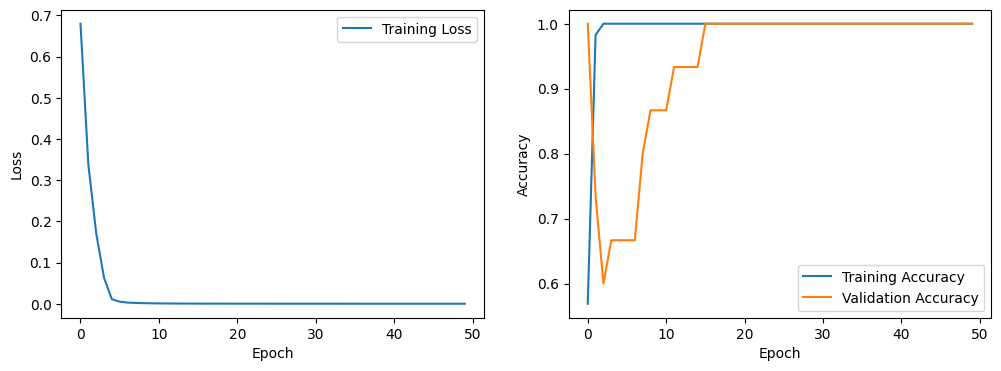

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
[[6 0]
 [0 9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import timm

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


This code is done in lab system 2nd from right.
100 epoch batch size 16

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\xception-43020ad28.pth


Epoch 1/100, Training Loss: 0.3894, Training Accuracy: 0.8448, Validation Accuracy: 1.0000
Epoch 2/100, Training Loss: 0.0118, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 3/100, Training Loss: 0.0012, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 4/100, Training Loss: 0.0005, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 5/100, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 6/100, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 7/100, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 8/100, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 9/100, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 10/100, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 11/100, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 1.00

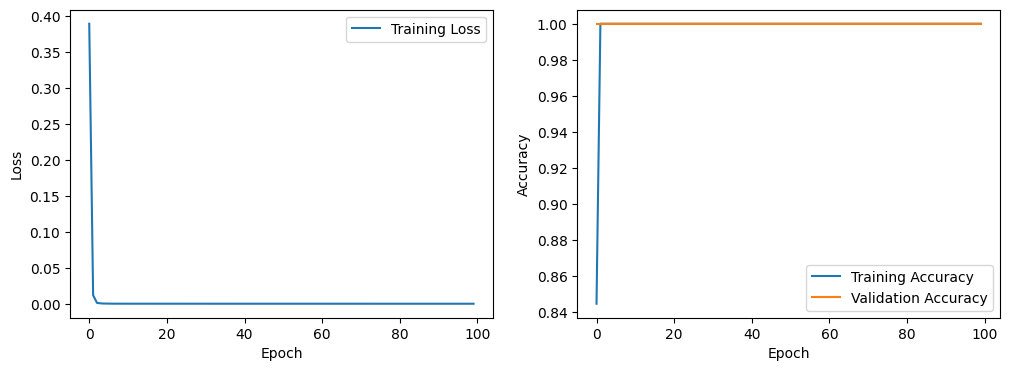

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
[[15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import timm

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=100):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\USER\Desktop\PD audio data\Spectrogram"
train_and_evaluate(data_path)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/15, Training Loss: 0.4248, Training Accuracy: 0.8103, Validation Accuracy: 0.3333
Epoch 2/15, Training Loss: 0.0229, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 3/15, Training Loss: 0.0117, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 4/15, Training Loss: 0.2508, Training Accuracy: 0.8966, Validation Accuracy: 1.0000
Epoch 5/15, Training Loss: 0.1037, Training Accuracy: 0.9483, Validation Accuracy: 1.0000
Epoch 6/15, Training Loss: 0.0591, Training Accuracy: 0.9828, Validation Accuracy: 1.0000
Epoch 7/15, Training Loss: 0.0222, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 8/15, Training Loss: 0.1321, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 9/15, Training Loss: 0.1977, Training Accuracy: 0.9310, Validation Accuracy: 0.8667
Epoch 10/15, Training Loss: 0.0507, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 11/15, Training Loss: 0.1116, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 12

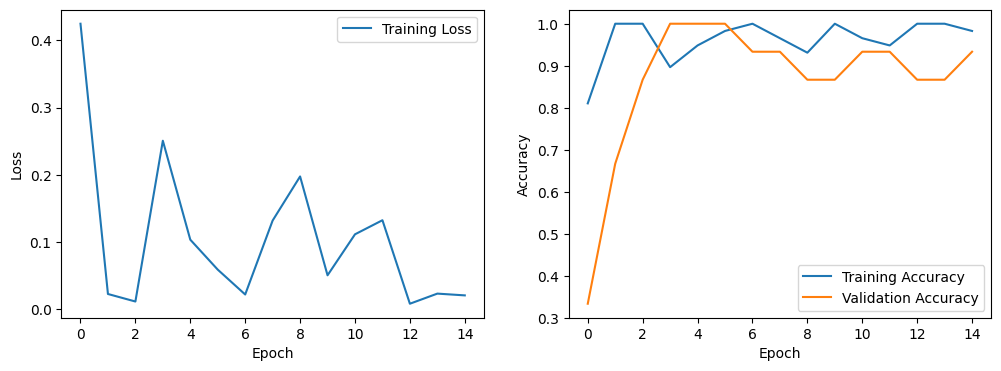

Final Training Accuracy: 0.9828
Final Validation Accuracy: 0.9333
Predicted Class Values: [1 0 1 1 1 0 0 1 1 1 0 1 1 1 0]
True Class Values: [1 0 1 1 1 0 0 1 1 1 0 1 1 1 1]
[[ 4  0]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.91      0.95        11

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15

Sensitivity: 0.9091
Specificity: 1.0000


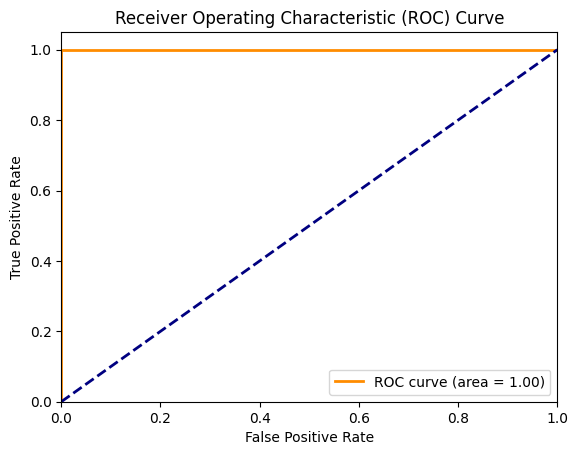

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=15):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/15, Training Loss: 0.4481, Training Accuracy: 0.6724, Validation Accuracy: 0.8667
Epoch 2/15, Training Loss: 0.1583, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 3/15, Training Loss: 0.0773, Training Accuracy: 0.9483, Validation Accuracy: 0.9333
Epoch 4/15, Training Loss: 0.0819, Training Accuracy: 0.9483, Validation Accuracy: 0.9333
Epoch 5/15, Training Loss: 0.0125, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 6/15, Training Loss: 0.0180, Training Accuracy: 1.0000, Validation Accuracy: 0.7333
Epoch 7/15, Training Loss: 0.0720, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 8/15, Training Loss: 0.0595, Training Accuracy: 0.9655, Validation Accuracy: 1.0000
Epoch 9/15, Training Loss: 0.0530, Training Accuracy: 0.9828, Validation Accuracy: 1.0000
Epoch 10/15, Training Loss: 0.0220, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 11/15, Training Loss: 0.0123, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 12

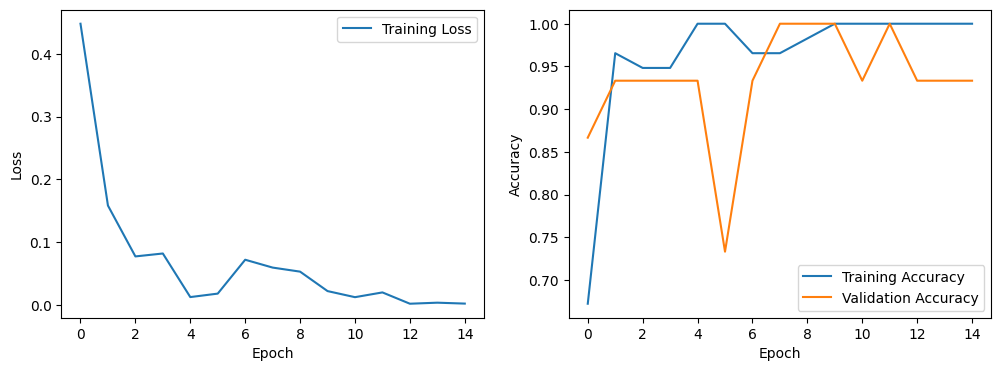

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9333
Predicted Class Values: [1 0 0 0 1 0 1 0 0 0 0 0 0 1 0]
True Class Values: [1 0 0 0 1 1 1 0 0 0 0 0 0 1 0]


NameError: name 'itertools' is not defined

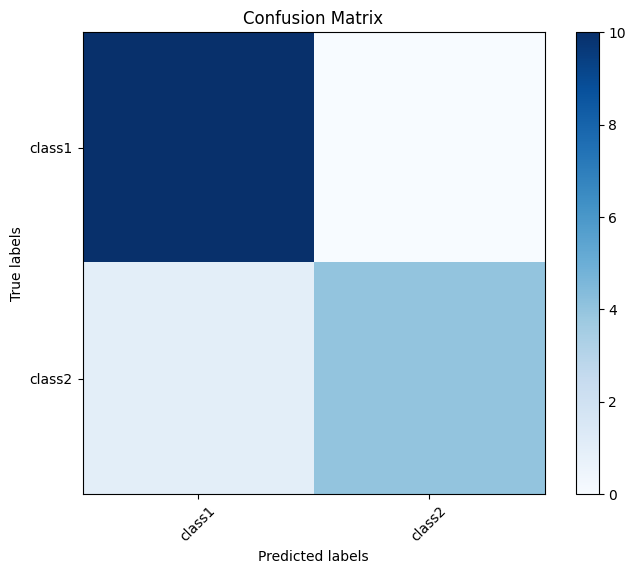

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=15):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    classes = ['class1', 'class2']  # Replace with your class labels
    plot_confusion_matrix(y_true, y_pred, classes)

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/15, Training Loss: 0.4406, Training Accuracy: 0.6897, Validation Accuracy: 0.8667
Epoch 2/15, Training Loss: 0.1659, Training Accuracy: 0.9310, Validation Accuracy: 0.7333
Epoch 3/15, Training Loss: 0.0156, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 4/15, Training Loss: 0.0342, Training Accuracy: 0.9828, Validation Accuracy: 0.8667
Epoch 5/15, Training Loss: 0.0556, Training Accuracy: 0.9828, Validation Accuracy: 0.8667
Epoch 6/15, Training Loss: 0.0676, Training Accuracy: 0.9828, Validation Accuracy: 0.8667
Epoch 7/15, Training Loss: 0.0212, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 8/15, Training Loss: 0.0066, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 9/15, Training Loss: 0.0567, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 10/15, Training Loss: 0.0071, Training Accuracy: 1.0000, Validation Accuracy: 0.7333
Epoch 11/15, Training Loss: 0.0650, Training Accuracy: 0.9655, Validation Accuracy: 0.8667
Epoch 12

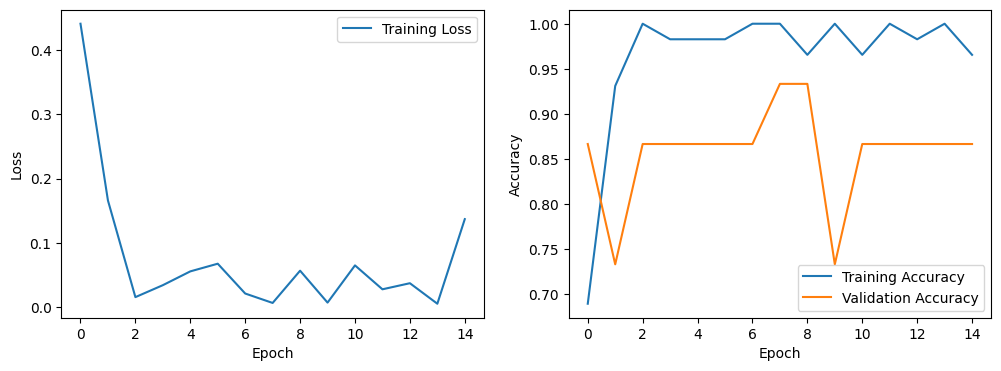

Final Training Accuracy: 0.9655
Final Validation Accuracy: 0.8667
Predicted Class Values: [1 1 1 0 0 1 1 0 0 0 0 1 1 1 0]
True Class Values: [1 1 1 0 0 1 0 0 0 1 0 1 1 1 0]
[[6 1]
 [1 7]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.88      0.88      0.88         8

    accuracy                           0.87        15
   macro avg       0.87      0.87      0.87        15
weighted avg       0.87      0.87      0.87        15

Sensitivity: 0.8750
Specificity: 0.8571


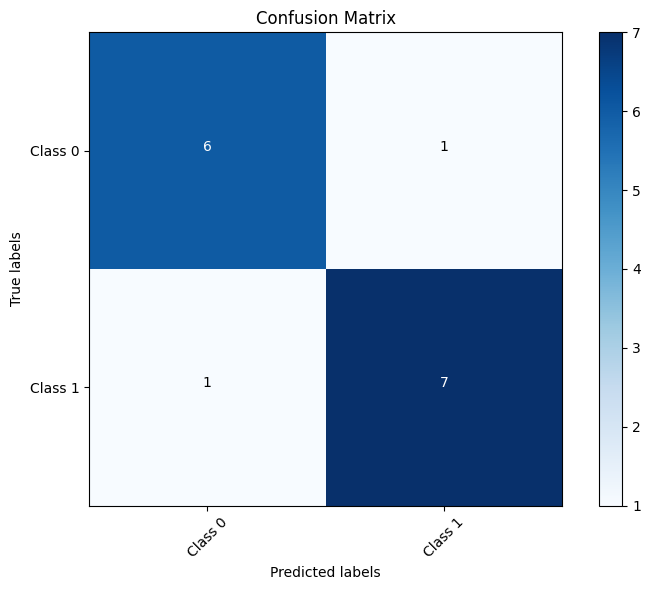

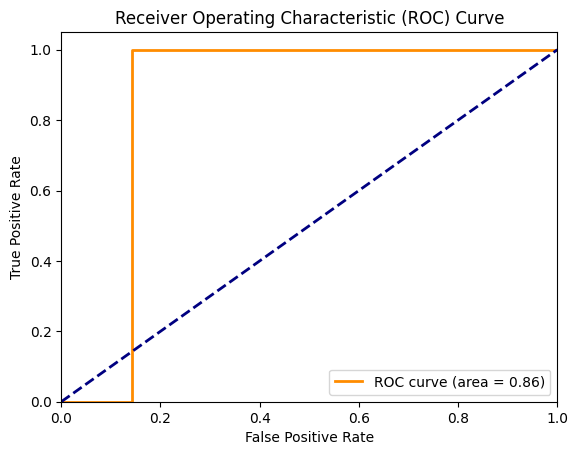

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=15):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['Class 0', 'Class 1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Sakar dataset -755 data point-

Done in lab computer

epoch 10
batch size 32
learning rate=0.0001

c:\Users\USER\Desktop\python_install\Python390\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\Desktop\python_install\Python390\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/10, Training Loss: 0.5001, Training Accuracy: 0.7732, Validation Accuracy: 0.7566


Epoch 2/10, Training Loss: 0.2303, Training Accuracy: 0.9222, Validation Accuracy: 0.8289


Epoch 3/10, Training Loss: 0.1108, Training Accuracy: 0.9652, Validation Accuracy: 0.8158


Epoch 4/10, Training Loss: 0.0743, Training Accuracy: 0.9801, Validation Accuracy: 0.7697


Epoch 5/10, Training Loss: 0.0344, Training Accuracy: 0.9950, Validation Accuracy: 0.8487


Epoch 6/10, Training Loss: 0.0293, Training Accuracy: 0.9934, Validation Accuracy: 0.8882


Epoch 7/10, Training Loss: 0.0153, Training Accuracy: 0.9967, Validation Accuracy: 0.8487


Epoch 8/10, Training Loss: 0.0968, Training Accuracy: 0.9636, Validation Accuracy: 0.8355


Epoch 9/10, Training Loss: 0.0645, Training Accuracy: 0.9768, Validation Accuracy: 0.8289


Epoch 10/10, Training Loss: 0.0180, Training Accuracy: 0.9950, Validation Accuracy: 0.8684


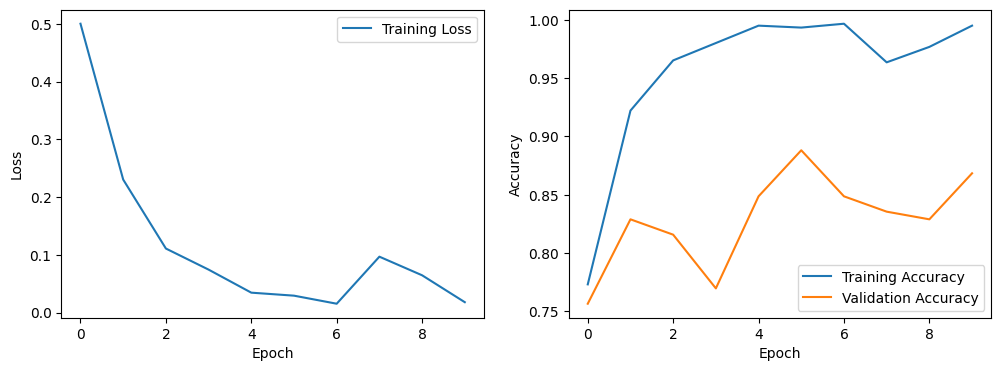

Final Training Accuracy: 0.9950
Final Validation Accuracy: 0.8684
Predicted Class Values: [0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1
 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1
 0 0 1 0]
True Class Values: [0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1
 0 0 1 0]
[[34  5]
 [15 98]]
              precision    recall  f1-score   support

           0       0.69      0.87      0.77        39
           1       0.95      0.87      0.91       113

    accuracy                           0.87       152
   macro avg       0.82      0.87 

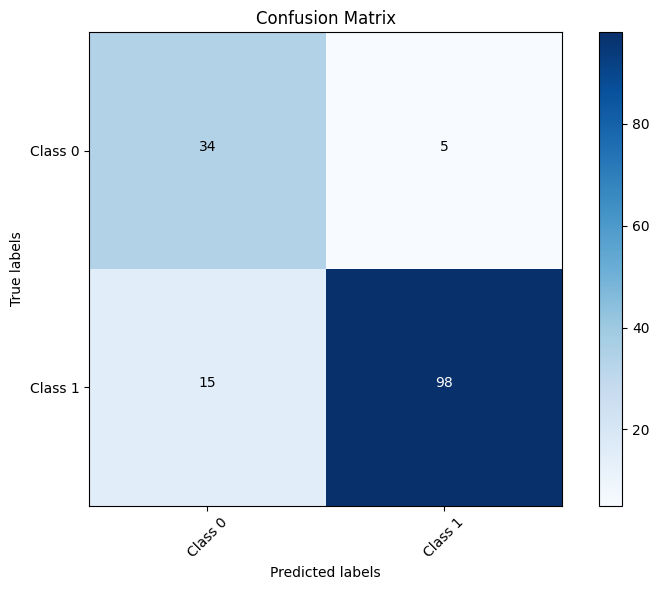

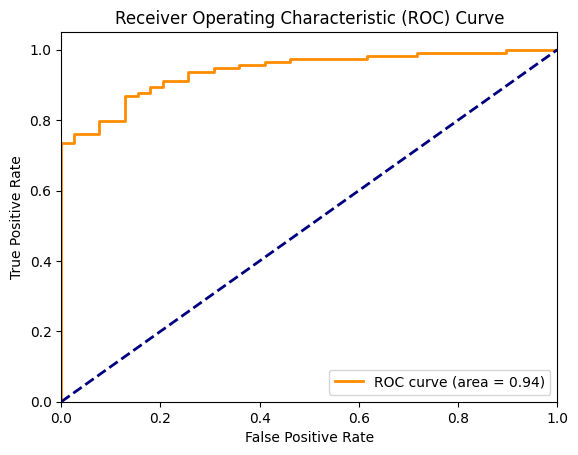

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm
from tqdm import tqdm

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 299, 299  # Xception expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        # Wrap train_loader with tqdm for progress bar
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_loader.set_postfix({'Loss': loss.item(), 'Accuracy': (predicted == labels).sum().item() / labels.size(0)})

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        # Wrap val_loader with tqdm for progress bar
        val_loader = tqdm(val_loader, desc='Validation', leave=False)
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)
                val_loader.set_postfix({'Accuracy': correct_val / total_val})

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['Class 0', 'Class 1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\USER\Downloads\PD audio\Sakar pd speech time series converted\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)
